## Predicting Procrastination 

### Executive Summary
The purpose of this project is to determine if one can dynamically predict whether or not they are procrastinating by interpreting the contents of the HTML of an arbitrary web page. In order to achieve this the raw HTML of individual web pages viewed over a one month period were recorded and manually classified as either being 'work' or 'procrastination'. Using various NLP techniques, these classified web pages were then cleaned, parsed, and used as the inputs for a Logistic Regression model. The outcome was incredibly successful, with the resulting model having prediction capabilties with over 97% accuracy. Ultimately, this approach is to become generalized and a pipeline is to be created that will allow any individual the ability to classisfy their browsing history with a browser based extension. This extension can then dynamically block content from being viewed in attempt to help the user stay focused on what they would consider more productive work.

### Introduction

The motiviation for this project came from my own personal struggles with procrastination. There exist many productivity apps out there to help people like me stay focused despite the seemingly infinite number of distractions that exist on the current state of the internet (*cough* Reddit *cough*). The problem is, most of these productivity apps block website purely off URL. In many cases this is good enough, but often times blocking an entire URL creates more problems than it solves. Youtube, for example, is one of the largest sources of distraction the internet has to offer. Naturally, it is a website one would block when they would like to be productive. However, Youtube also provides a vast wealth of incredibly informative videos. There have been numerous times when watching a five minute video on matrix multiplication to refresh my memory would lead to hours of increased productivity down the line. But alas, the site is blocked by my supposedly helpful productivity app. So I find myself in at a crossroads: I can disable the app to watch the video I want to see, but run the risk of spiraling down a never ending path of cat videos; or I leave the app running and search for a less effective refresher. I should not have to choose. So I set out to find a better way.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

%matplotlib inline

## Importing Data

The code for the parsing and cleaning is in the data cleansing notebook. You can go there for a more detailed breka down of how the data was cleansed.

In [4]:
data = pd.read_csv('parsed_html.csv')
X = data[['text','url']]

# Splitting our data into a training and test set before we begin our data building
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, data.activity,test_size=0.33, random_state=43)

## Model building

#### Building a grid searched pipeline

I am using a grid search over a pipeline to find the best model to use. After much trial and error I settled on a logistic regression model. First off it simply performaned the best. But additionally it is by far the most interpretible model. Also, Lasso Regularization is a great way to reduce the number of features generated by the countvectorization process, and the use of ngrams. At one point I had a dataframe with over 2,000,000 features. Lasso Regularization reduced that to a few hundred.

In [3]:
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

# Let's create some stop words. I chose these values after doing a little bit of EDA.
stop = stopwords.words('english')
stop = stop + ['https', 'www', 'com', 'http']
cvt = CountVectorizer(stop_words=stop, ngram_range=[1,4])

# Here we are initializing the values we want to grid search over.
param_grid = dict(vect = [CountVectorizer()],
                  vect__ngram_range=[[1,3],[1,4]], # Trying different ngram ranges
                  vect__stop_words = [stop],
                tfidf = [TfidfTransformer()],
                tfidf__norm = [None],
                clf=[LogisticRegression()],
                clf__C=[.04,.1,.06, .07, .05], # Trying different coefficients for alpha
                clf__penalty=['l1'])
            

pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer(norm=None)),
    ('clf', LogisticRegression(penalty='l1'))
]) 

grid_search = GridSearchCV(pipeline, param_grid=param_grid)

grid_search.fit(X_train.text, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=[1, 4], preprocessor=None,
        stop_words=['i', 'me',...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=[1, 4], preprocessor=None,
        stop_words=['i', ...     verbose=0, warm_start=False)], 'clf__C': [0.04, 0.1, 0.06, 0.07, 0.05], 'clf__penalty': ['l1']},
       pre_dispatch='2*n_jobs', refit=True, return_

## Analyzing our results

#### Calculating some metrics

In [6]:
# Finding our best pipeline and pulling out the useful components
pipeline = grid_search.best_estimator_
lm =  pipeline.named_steps['clf']
vect = pipeline.named_steps['vect']

# Let's see what our accuracy looks like
grid_search.best_estimator_.score(X_test.text, y_test)

0.97493036211699169

Our accuracy score is looking great. 97.5% is great, but we should compare it to our baseline distribution before we get to excited.

In [7]:
# Caluclating our baseline
(y_train == 'work').sum()/float(len(y_train))

0.41483516483516486

So we have massively improved over random chance. This is a good start. We should look at some additional metrics as well to see if we have anything to be concerned about.

In [8]:
result_x = vect.transform(X_test.text)

pred = lm.predict(result_x)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      procr       0.96      0.98      0.97       214
       work       0.96      0.94      0.95       145

avg / total       0.96      0.96      0.96       359



So far so good. I don't see anything that looks particurally concerning with these results. Our recall being a little less for work then procrastination is something to keep in mind going forward. We may want to consider examining our predict probabilities to see what kind of values are getting misclassified.

Next we should take a look at our ROC and the area under the curve.

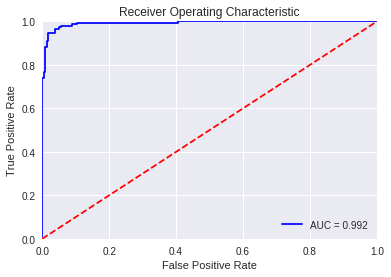

In [9]:
from sklearn.metrics import roc_curve, auc
# Here is some helpful code found on stack overflow
pred_proba = lm.predict_proba(result_x)
fpr, tpr, threshold = roc_curve(y_test == 'work', pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

Wow! 0.992 AUC_ROC. That is amazing. I think we can safely say we have created an extremely effective model for predicting procrastination.

#### Taking a deeper look at our features

In [10]:
# This bit of code is pulling out my features that have coefficients greater than zero
# Lasso regularization reduces the coef to 0 of the features (in our case unique ngrams)
import math
features =(vect.get_feature_names())
feature_dict = {}
for (i, f) in enumerate(features):
    if np.abs(lm.coef_[0][i]) > 0:
        feature_dict[f] = lm.coef_[0][i]

In [11]:
# For convienence sake I'll put the features into a data frame for easier exploration
feature_df = pd.DataFrame.from_dict(feature_dict, orient='index')
feature_df.columns = ['coef']

Let's take a quick look at the number of features and our total documents. We really do not want a model utilizing more features than we have documents. Our reguralization should have accounted for this, but it's not a bad idea to double check.

In [12]:
# How many documents do I have in my training set
print("Number of docs: " + str(len(X_train)))

# How many features do I have after reguralization
print("Number of features: " + str(len(feature_df)))

Number of docs: 728
Number of features: 163


In [13]:
# We can raise our logisitic regression coef to the e to calculate the odds ratio
feature_df['odds_ratio'] = feature_df['coef'].apply(np.exp)

Now let's look at what words are most associated with procrastination and productivity. We can sort our dataframe by odds ratio. The smaller odds ratio means words that are less related productivity, and a higher ratio means more related.

In [14]:
feature_df.sort_values('odds_ratio').head(10)

,coef,odds_ratio
game,-0.134186,0.874428
reddit,-0.081973,0.921296
likes,-0.077123,0.925776
src,-0.066932,0.935259
photo,-0.058546,0.943135
attack,-0.057227,0.944379
video,-0.039879,0.960905
append,-0.039168,0.961590
thwas,-0.039122,0.961633
us,-0.038034,0.962680


In [15]:
feature_df.sort_values('odds_ratio', ascending=False).head(10)

,coef,odds_ratio
github,0.160269,1.173826
using,0.157616,1.170717
data,0.104888,1.110586
file,0.069604,1.072083
import,0.063412,1.065466
code,0.057361,1.059038
stack,0.050158,1.051437
instagram,0.048071,1.049245
friction,0.046981,1.048102
kurzgesagt,0.037711,1.038431


Looking at the top 10 words related to procrastinating I can see a lot of things that make sense. Words like 'game', 'reddit', 'photo' make sense in a general sense. '5e' and 'attack' look related to Dungeons and Dragons (I thing I spend a lot of time reading about). 'src', 'us', and 'thwas' I don't undrestand as much.

The top 10 words for being productive are almost all really clear to me. 'github' being the strongest indicator comes at no suprise, with 'data', 'file', 'code', and 'import' all following closely behind. The word 'using' is interesting. I do find myself googling phrases like "classifying data using logistic regression' quite frequently, perhaps that verb is largely prevelant in sentences for when I'm being productive. 'instagram' is another interesting word. I do not use instagram. I don't even have an account. But I did spend a long afternoon one day trying to figure out how to get their API to work for a project I was working on. 'Kurzgesagt' is the name of a Youtube channel for educational videos. I am extremely please to see it show up as an indicator of producitivity. That is a text book example of the kind of key word I was hoping to find that would distinguish mindless youtube videos from educational ones.

#### Investigating miss-classified events

I would like to better understand in what use cases my model miss-classified a website. What were the probabilities like? What kind of content was it trying to classifiy? To do that I'm going to need to write a little bit of exploritory code.

In [16]:
# I am going to create a score column. This is just going to be the probability mulitplied by 100.
X_test['prob_work'] = list(lm.predict_proba(result_x)[:,1]*100)

/home/roland/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
X_test['prob_work'] = list(X_test.prob_work.apply(int))
X_test['predict']  = list(lm.predict(result_x))

/home/roland/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/roland/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
# Now let us look at what what value do not overlap in out test dataset
X_test[X_test.activity != X_test.predict]

,activity,text,timestamp,url,prob_work,predict
817,procr,AnyDice AnyDice Dice Probability C...,2017-7-27-11-0-51,NaN,56,work
146,work,K-means Clustering : pystatsjump to contentMy ...,2017-7-25-19-59-3,NaN,42,procr
494,procr,dnd 5e - Multiclass Warlock/Wizard: Can I use...,2017-7-24-10-22-3,NaN,75,work
527,work,Ph.D Data Scientists who loved doing their Ph....,2017-7-21-11-50-51,NaN,48,procr
996,procr,[OC] snapchat heat map aligning with path of E...,2017-8-21-15-13-0,https://www.reddit.com/r/dataisbeautiful/comme...,54,work
388,procr,Python (genus) - Wikipedia ...,2017-8-5-3-23-47,NaN,72,work
775,work,Datasetsjump to contentMy Subreddits-Dashboard...,2017-8-14-10-41-1,https://www.reddit.com/r/datasets/,48,procr
426,work,Balances ...,2017-8-22-14-9-28,https://ebranch.nasafcu.com/HBNet/App/Account/...,48,procr
854,work,Python-written open source tool to transform e...,2017-7-25-19-52-37,NaN,38,procr
859,procr,Dead-Baby Jokes about | contac...,2017-8-18-12-34-50,http://www.skrause.org/humor/deadbaby.shtml,50,work


There is a lot to explore here. The one trend that I see immediately is that most of these miss-classifications do not have very confident scores. They all have scores somewhere between 25-75 with the exception of the last result. I need to investigate that last result further, but from what I can tell it appears that I may have pressed the wrong button when classifying the data.

In [19]:
# looking at the raw text of our miss-classified test data.
X_test.loc[611].text[0:2000]

'[Highlight] Bengals punter Kevin Huber behind the back move : nfljump to contentMy Subreddits-Dashboard-home-popular-All-Random-Friends-Saved-edit|add shortcuts from the my subreddits menu at left or click the button by the subreddit name, drag and drop to sort↑↓>\uf139<reddit.com\xa0nflcommentsother discussions (1) show images JustARegularGuy\xa0(825    ·    9,744)|messages0|preferences||logoutlimit my search to r/nflSort:relevancenewhottopcomments Time:all timethis hourtodaythis weekthis monththis year[-]use the following search parameters to narrow your results:subreddit:subredditfind submissions in "subreddit"author:usernamefind submissions by "username"site:example.comfind submissions from "example.com"url:textsearch for "text" in urlselftext:textsearch for "text" in self post contentsself:yes (or self:no)include (or exclude) self postsnsfw:yes (or nsfw:no)include (or exclude) results marked as NSFWe.g. subreddit:aww site:imgur.com dogsee the search faq for details.advanced searc

The raw text appears to be from the r/baseball subreddit which definitely was recorded while procrastinating. It is almost certianly mistakenly classified as being productive because of a misclick. There are likely many of these mistakes scattered throughout our training data as well. It is difficult to understand how manually miss-classified data is effecting our overall result, but for the sake of brevity we are going to consider this event an outlier that we cannot address.

I am more interested in the other events, and how frequenty we get probabilities with similar scores to the miss-classified scores (the range between 25-75). This might be best explored with a visualization.

In [20]:
# Let's start by classifying what percent of our data falls in this danger zone.
len(X_test[(X_test.prob_work <=75) & (X_test.prob_work >= 25)])/len(X_test)

0.19498607242339833

Just under 20% of our data is in this unclear zone. I'd like to compare the accuracy of the data in this mid zone to the accuracy of our data in the edge region.

In [21]:
mid_zone = X_test[(X_test.prob_work <=75) & (X_test.prob_work >= 25)]
good_zone = X_test[(X_test.prob_work >75) | (X_test.prob_work < 25)]

In [22]:
# Some quick math to compare the amount of data in each zone (really just double checking here)
print("Number in good zone: " + str(len(good_zone)))
print("Number in mid zone: " + str(len(mid_zone)))

Number in good zone: 289
Number in mid zone: 70


In [23]:
print("Accuracy good_zone: " + str(1 - len(good_zone[good_zone.activity != good_zone.predict])/len(good_zone)))

Accuracy good_zone: 0.9965397923875432


In reality this value should be 100, because as we discussed earlier this data was manually mis-classified and the model actually predicted it correctly.

In [24]:
print("Accuracy mid_zone: " + str(1 - len(mid_zone[mid_zone.activity != mid_zone.predict])/len(mid_zone)))

Accuracy mid_zone: 0.8285714285714285


This is more interesting. When we do not have a strong predictor our accuracy falls pretty significantly. We could almost consider introducing a 3rd category into our classification; a category for unsure. Even though we are still respectively accurate in this mid zone. Out of curioustiy what is the baseline for these respective regions.

In [25]:
# Caluclating our baseline for good zone
print("Baseline good_zone: " + str((good_zone.activity == 'work').sum()/float(len(good_zone))))
print("Baseline mid_zone: " + str((mid_zone.activity == 'work').sum()/float(len(mid_zone))))

Baseline good_zone: 0.370242214533
Baseline mid_zone: 0.542857142857


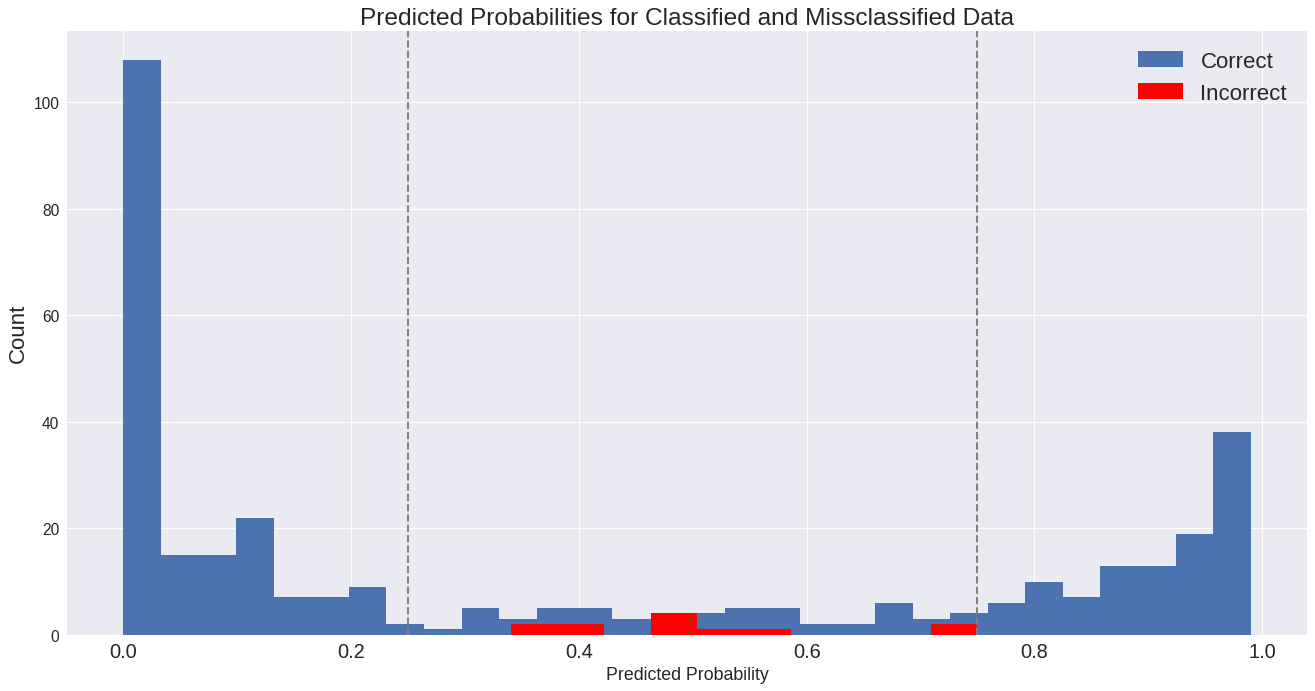

In [55]:
# Correcting the bad data point
X_test.set_value(610, 'activity', 'procr')
plt.figure(figsize=(20,10), dpi=80)
good = X_test[X_test.activity ==X_test.predict]
bad = X_test[X_test.activity !=X_test.predict]
g_= plt.hist(good.prob_work/100, bins=30,alpha=1)
b_ =plt.hist(bad.prob_work/100, alpha=1, color='red')
plt.legend(['Correct', 'Incorrect'], fontsize=20)
plt.axvline(x=.25, color='grey', linestyle='--')
plt.axvline(x=.75, color='grey', linestyle='--')
plt.yticks(fontsize=14)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=18)
plt.xlabel("Predicted Probability" ,fontsize=16)
plt.title("Predicted Probabilities for Classified and Missclassified Data", fontsize=22)
